# 1 GAN 

## 1.1 Data
You can find a dataset on the Moodle website (ising data.zip). These are some Monte Carlo samples
of the standard ferromagnetic 2D Ising model on a square lattice of size $40x40$ generated at different
temperatures. For each temperature there are 1001 spin configurations. The factor indicates how
close it is to the critical temperature (e.g. 1 corresponds to $0.1\beta_c$, $\beta_c = 1/(T_c k_B)$). It contains various
numpy arrays so you can load the datasets using numpy.

In [31]:
import numpy as np
import os

data = {}
temps = []
# go through all files in the folder "ising data"
for file in os.listdir("ising_data"):
    t = int(file.split(".")[0].split("_")[1])
    # add the data of each file to the data dictionary
    data[t] = (np.load("ising_data/" + file))
    # add the name of the file to temps
    temps.append(t)
    

print("Shape of the data which was loaded from the folder ising_data: " + str(data[11].shape))
print("Temperatures:")
print(temps)


Shape of the data which was loaded from the folder ising_data: (1001, 40, 40)
Temperatures:
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


## 1.2 GAN Implementation
Build a GAN with a custom training loop (as in sheet 10) that aims at generating Ising samples
below the critical temperature. Analyze the energy and magnetization of both the original dataset
and the generated Ising samples.
Note that in case you do not have a local environment where you can calculate on a GPU, you
can calculate online on collab on a GPU.

In [32]:
# import the libraries
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import GradientTape
from tensorflow.python.data import Dataset
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, BatchNormalization, Activation, Input, Reshape, Flatten, Dropout, GlobalMaxPooling2D, Conv2D, Conv2DTranspose
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [33]:
class GAN:
    """
    Class to build and fit a GAN.
    """
    def __init__(self, temp_data, num_classes=10, batch_size=128):
        self.x_train = temp_data
        # the gerated images will have values between 0 and 1 --> rescale the real images
        for i in range(len(self.x_train)): 
              self.x_train[i] = (self.x_train[i]+1)/2

        self.train_dataset = None
        self.generator = None
        self.discriminator = None
        self.batch_size = batch_size
        self.gen_optimizer = Adam(1e-4)
        self.discr_optimizer = Adam(1e-4)

        self.input_shape = self.x_train[0].shape
        self.latent_dim = (128,)
    
    def losses(self):
        """ Define the loss functions for discriminator and generator. """
        def discriminator_loss(real_output, fake_output):
            real_loss = BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
            fake_loss = BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
            total_loss = real_loss + fake_loss
            return total_loss
        def generator_loss(fake_output):
            return BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)
        return generator_loss, discriminator_loss    
    

    def build_generator(self):
        """ Build the generator model. """
        """"
        model = Sequential(name="Generator")
        # input: shape (100,)
        model.add(Input(shape=self.latent_dim))
        #model.add(Dense(6000))
        #model.add(LeakyReLU(alpha=0.2))
        # add a dense layer with batch size *10* 10 nodes and reshape it to 
        # (batch size, 10, 10)
        model.add(Dense(self.batch_size*100))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((10, 10, self.batch_size)))
        # go from (batch size, 10, 10) to (batch size, 40, 40) which is the desired
        # output shape
        model.add(Conv2DTranspose(self.batch_size, (2, 2), strides=(2, 2), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2DTranspose(self.batch_size, (2, 2), strides=(2, 2), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(1, (10, 10), padding="same", activation="sigmoid"))
        # output: shape (batch size, 40, 40)
        model.add(Reshape(self.input_shape))
        """

        dim = 10
        batch_size = self.batch_size
        depth = dim*dim*batch_size

        model = Sequential(name="Generator")
        model.add(Dense(depth, use_bias=False, input_shape=self.latent_dim))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Reshape((dim, dim, batch_size)))

        # go from (batch size, 10, 10) to (batch size, 40, 40)
        model.add(Conv2DTranspose(batch_size, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(batch_size, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

        # output: shape (batch size, 40, 40)
        model.add(Reshape(self.input_shape))

        self.generator = model
        self.generator.summary()
        
    def build_discriminator(self):
        """ Build the discriminator model. """

        model = Sequential(name="Discriminator")
        model.add(Input(shape=self.input_shape))
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1))
        model.summary()
        self.discriminator = model
        """

        model = Sequential(name="Discriminator")
        model.add(Input(shape=(40, 40, 1)))
        model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
        model.add(LeakyReLU())
        model.add(Dropout(0.3))

        model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
        model.add(LeakyReLU())
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(1))

        self.discriminator = model
        self.discriminator.summary()
        """


                         
    
    def build_full_GAN(self):
        """ Build the full GAN. """
        self.build_generator()
        self.build_discriminator()


    def fit_data_custom(self, epochs=10):
        """ Fit the data with a custum training loop. """
        # Create batches
        self.build_batches()

        for epoch in range(epochs):
            print("Beginning epoch ", epoch + 1)
            # Go through the images of each batch and create fake images.
            for images in self.train_dataset:
                generated_images = self.execute_training_step(images)
            # output the fake and real images, energy and magnetization of the last batch.
            self.plot_configurations(images, generated_images)
            real_magnetization = self.calculate_magnetization(images)
            fake_magnetization = self.calculate_magnetization(generated_images)
            print("real average magnetization: " + str(real_magnetization) + ", fake average magnetization:" + str(fake_magnetization))
            real_energy = self.calculate_energy(images)
            fake_energy = self.calculate_energy(generated_images)
            print("real average energy: " + str(real_energy) + ", fake average energy:" + str(fake_energy))


    def build_batches(self):
        self.train_dataset = Dataset.from_tensor_slices((self.x_train))
        self.train_dataset = self.train_dataset.shuffle(buffer_size=len(self.x_train))
        self.train_dataset = self.train_dataset.batch(self.batch_size)

    # Remove this to check timing
    @tf.function
    def execute_training_step(self, images):
        # Generate the input for the generator: random noise with the right shape.
        noise = tf.random.normal([self.batch_size, self.latent_dim[0]])
        # Get the losses
        generator_loss, discriminator_loss = self.losses()
        with GradientTape() as gen_tape, GradientTape() as disc_tape:
            # Generate the fake images.
            generated_images = self.generator(noise, training=True)

            # Classify the real and fake images.
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            # Calculate the loss.
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)
        # Track the gradients of both models.
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discr_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return generated_images


    def plot_configurations(self, real_images, fake_images):
        """ Plots the spin configurations of the ising model. """
        f, axs = plt.subplots(1,2)
        axs[0].imshow(real_images[0], vmin=0, vmax=1)
        axs[1].imshow(fake_images[0], vmin=0, vmax=1)
        axs[0].title.set_text("real image")
        axs[1].title.set_text("fake image")
        f.set_figheight(10)
        f.set_figwidth(10)
        plt.show()

    def calculate_magnetization(self, images):
        """ Calculates the average magnetization of several images. """
        average_magnetization = 0
        for image in images:
            average_magnetization += abs(np.sum(image))
        # divide it by the number of images and the maximal magnetization (40*40)
        average_magnetization = average_magnetization/(len(images)*40*40)
        # the samples have values between 0 and 1 --> rescale the magnetization
        average_magnetization = abs((average_magnetization*2)-1)
        return average_magnetization

    def calculate_energy(self, images):
        """ Calculates the average energy of several images. """
        average_energy = 0
        for image in images:
          # the samples have values between 0 and 1 --> rescale them
            image = (image*2) -1
            e = 0
            for i in range(40):
                for j in range(40):
                    if j < i:
                      e += - image[i,j] * (image[i, (j+1)%40] + image[(i+1)%40, j])
            average_energy += e
        average_energy = average_energy/len(images)
        return average_energy.numpy()
        
            
    



### The GAN
Look at the generator and the discriminator:
- the generator starts with self.latent_dim (here 100) and outputs self.input_dim (here 40x40)
- the discriminator starts with self.self.input_dim (here 40x40) and classifies (dimension 1)

In [34]:
# Take the data at a specific temperature 
temp_data = data[11]
print(data[11].shape)

# Create a GAN instance and build the GAN
gan = GAN(temp_data)
gan.build_full_GAN()

(1001, 40, 40)
Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 12800)             1638400   
_________________________________________________________________
batch_normalization_21 (Batc (None, 12800)             51200     
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 12800)             0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 10, 10, 128)       409600    
_________________________________________________________________
batch_normalization_22 (Batc (None, 10, 10, 128)       512       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 10, 10

### Before the training
Without training, the generator produces images like on the left, but the real configurations look like on the right:

(1, 40, 40)


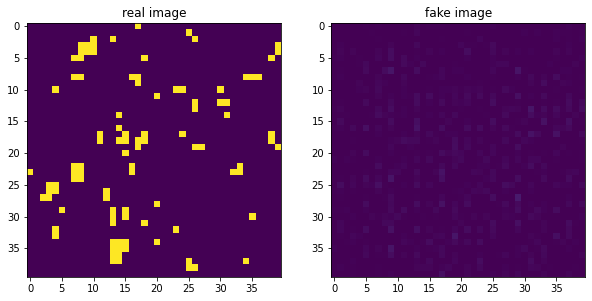

In [35]:
# generate noise as input for the generator, and generate an image
noise = tf.random.normal([1, gan.latent_dim[0]], mean=0.0)
generated_image = gan.generator(noise, training = False)
print(generated_image.shape)
# look at a real and a fake image
gan.plot_configurations(gan.x_train, generated_image)

### Training
Now we train the GAN:

Beginning epoch  1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


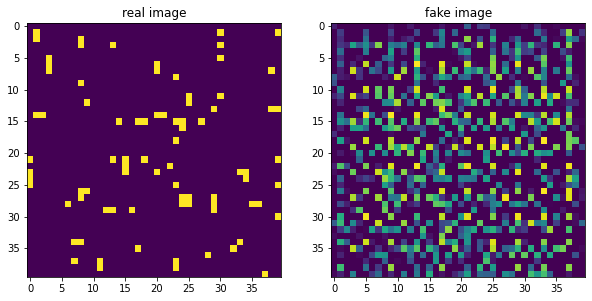

real average magnetization: 0.8868809523809524, fake average magnetization:0.8818065365403891
real average energy: 0.22857143, fake average energy:-1851.6146
Beginning epoch  2


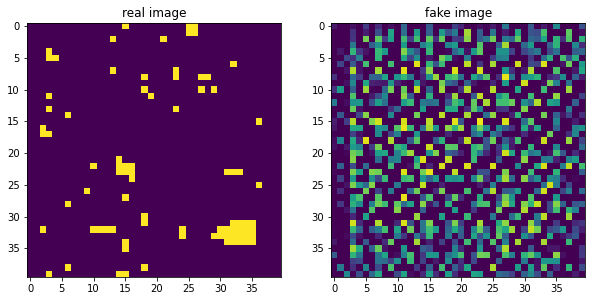

real average magnetization: 0.8867380952380952, fake average magnetization:0.9882660288969055
real average energy: 0.7619048, fake average energy:-1446.7886
Beginning epoch  3


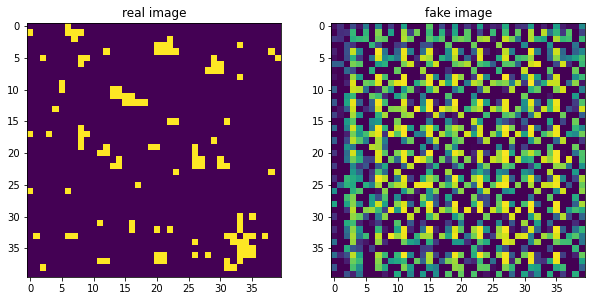

real average magnetization: 0.8823214285714286, fake average magnetization:0.7929171665012836
real average energy: -0.41904762, fake average energy:-1057.3057
Beginning epoch  4


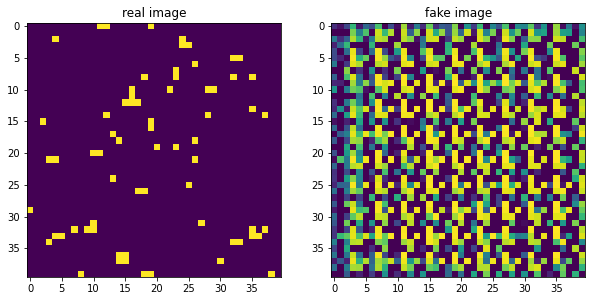

real average magnetization: 0.8862619047619048, fake average magnetization:0.8001493391394615
real average energy: 0.07619048, fake average energy:-852.2856
Beginning epoch  5


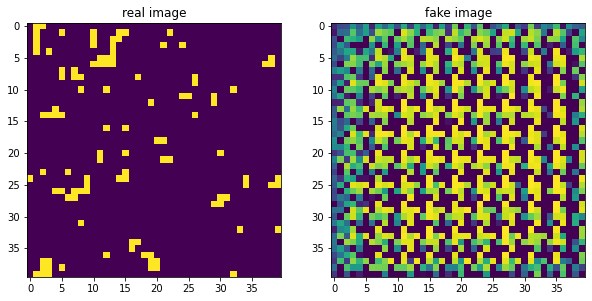

real average magnetization: 0.8866785714285714, fake average magnetization:0.7326430116593838


KeyboardInterrupt: 

In [36]:
# fit the GAN
gan.fit_data_custom(20)